In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# ====== Generating Dataset ====== #
r = np.random.rand(10000) * 3
theta = np.random.rand(10000) * 2*np.pi

y = r.astype(int)
r = r * (np.cos(theta) + 1)

x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

In [8]:
# ====== Split Dataset into Train, Validation, Test ====== #
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

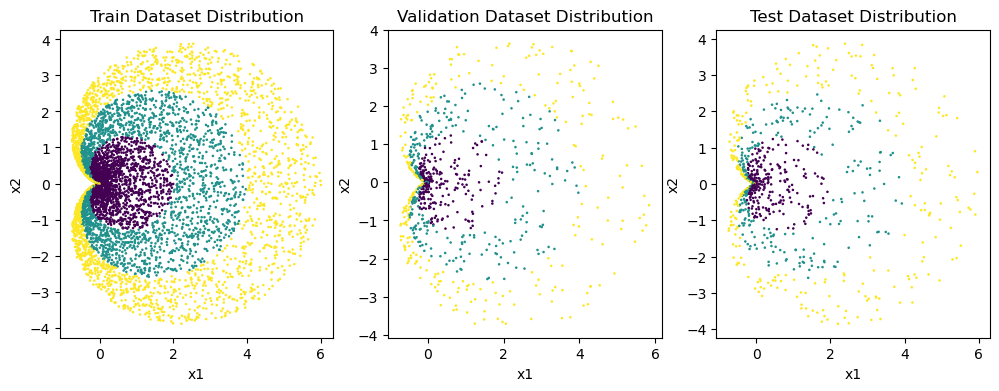

In [9]:
# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.scatter(train_X[:,0], train_X[:,1], c=train_y, s=0.7)
ax1.set_xlabel('x1'); ax1.set_ylabel('x2')
ax1.set_title('Train Dataset Distribution')

ax2 = fig.add_subplot(132)
ax2.scatter(val_X[:,0], val_X[:,1], c=val_y, s=0.7)
ax2.set_xlabel('x1'); ax2.set_ylabel('x2')
ax2.set_title('Validation Dataset Distribution')

ax3 = fig.add_subplot(133)
ax3.scatter(test_X[:,0], test_X[:,1], c=test_y, s=0.7)
ax3.set_xlabel('x1'); ax3.set_ylabel('x2')
ax3.set_title('Test Dataset Distribution')

plt.show()

In [10]:
# ====== Hypothesis Define ====== #
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.linear(x)
        x = self.softmax(x)
        return x

class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# model = LinearModel()
# print(model.linear.weight)
# print(model.linear.bias)

---

## **Cost Functions in Deep Learning Classification**

### **Cross-Entropy: Definition and Meaning**

Cross-entropy is a cost function used to measure the difference between a model's **predicted probability distribution** and the **true probability distribution**. A lower value indicates that the model's predictions are closer to the actual labels.

$$
C(P, Q) = -\sum_{x} P(x) \log Q(x)
$$
- $P(x)$: true probability of class $x$
- $Q(x)$: predicted probability of class $x$

* **Binary Classification**

    $$L(y, \hat{y}) = -[y \log(\hat{y}) + (1-y) \log(1-\hat{y})]$$

    * $y$: True label (0 or 1)
    * $\hat{y}$: Predicted probability of the positive class

* **Multi-class Classification**

    $$L(y, \hat{y}) = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)$$

    * $C$: Total number of classes
    * $y_i$: 1 if the $i$-th class is the true label, 0 otherwise (one-hot encoded)
    * $\hat{y}_i$: Predicted probability for the $i$-th class

### **Why Cross-Entropy is Used in Classification instead of MSE?**

#### **Connection to Maximum Likelihood Estimation**
Cross-entropy is deeply connected to the principle of **Maximum Likelihood Estimation (MLE)**. By minimizing cross-entropy, a model is optimized to make its predicted probability distribution as close as possible to the true label distribution.

#### **The Vanishing Gradient Problem with MSE**
The key issue with using **MSE** for classification lies in the **vanishing gradient problem**. In classification models, the output layer often uses activation functions like Sigmoid or Softmax, which have very small gradients when the output is close to 0 or 1. With MSE, a large error can still produce a tiny gradient, making the learning process extremely slow or ineffective.

#### **Cross-Entropy's Solution**
Cross-entropy avoids this issue through its mathematical formulation that cancels out the derivative of the activation function, ensuring that the gradient remains large even for confident but incorrect predictions. This allows for faster and more stable learning, as the model can aggressively update its weights to correct significant errors.

---

In [11]:
# ====== Cost Function Define ====== #
cls_loss = nn.CrossEntropyLoss()

# Pytorch CrossEntropyLoss Documentation
# URL: https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

# # Test Cost Function
# test_pred_y = torch.Tensor([[2, 0.1], [0, 1]])
# test_true_y1 = torch.Tensor([1,0]).long()   # true value: class index (should be integer type)
# test_true_y2 = torch.Tensor([0,1]).long()
#
# print(cls_loss(test_pred_y, test_true_y1))
# print(cls_loss(test_pred_y, test_true_y2))

1203 parameters


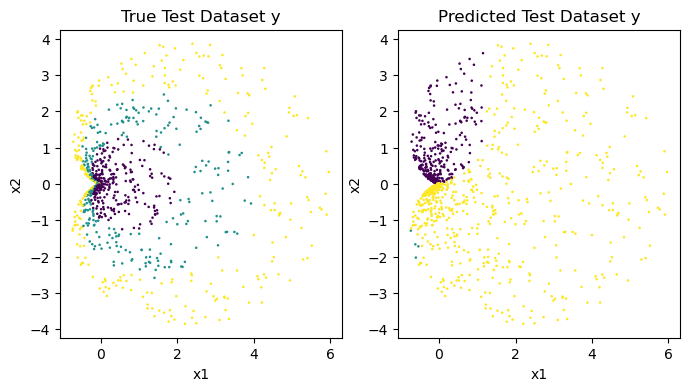

Epoch: 0, Accuracy: 34.50 %


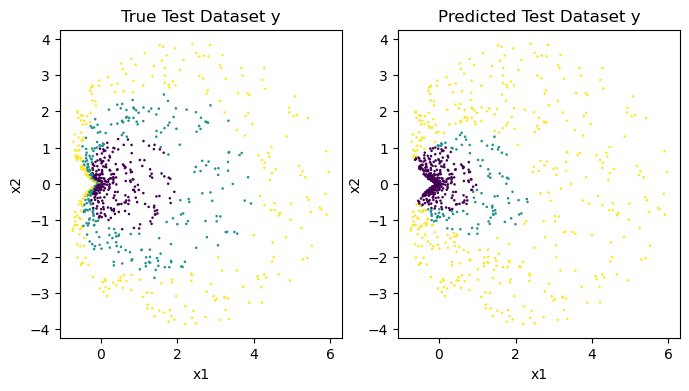

Epoch: 200, Accuracy: 54.80 %


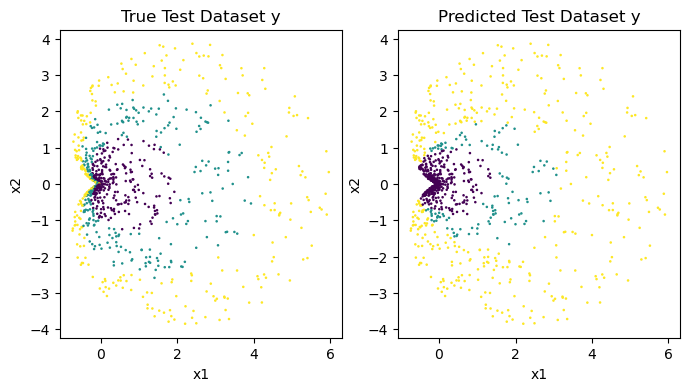

Epoch: 400, Accuracy: 60.70 %


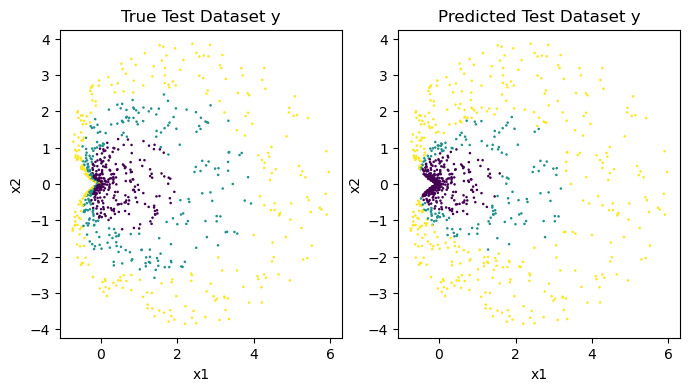

Epoch: 600, Accuracy: 64.10 %


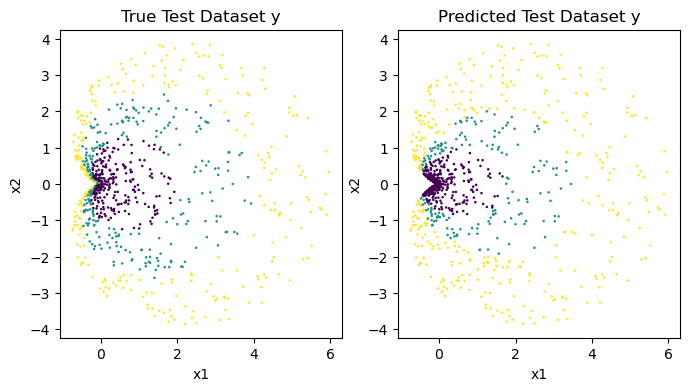

Epoch: 800, Accuracy: 67.00 %


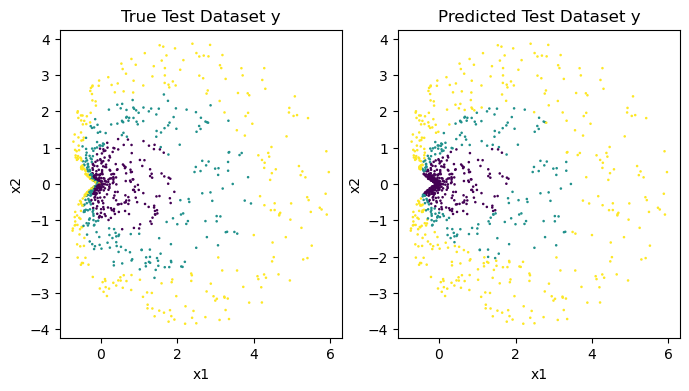

Epoch: 1000, Accuracy: 70.00 %


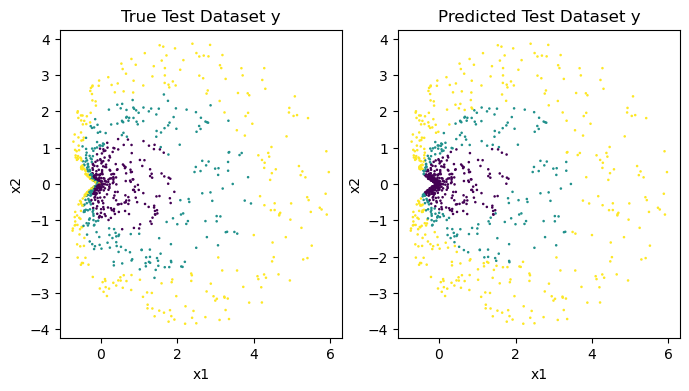

Epoch: 1200, Accuracy: 71.20 %


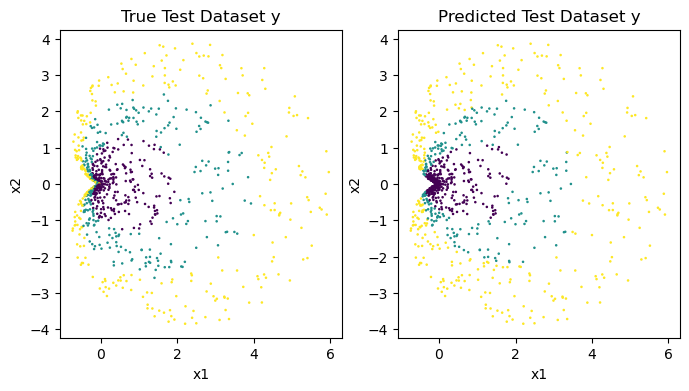

Epoch: 1400, Accuracy: 72.00 %


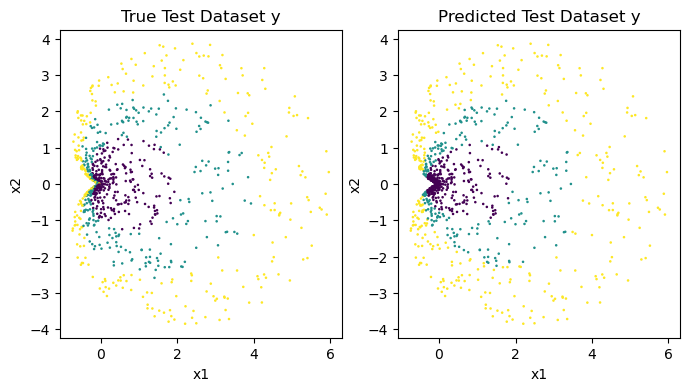

Epoch: 1600, Accuracy: 73.00 %


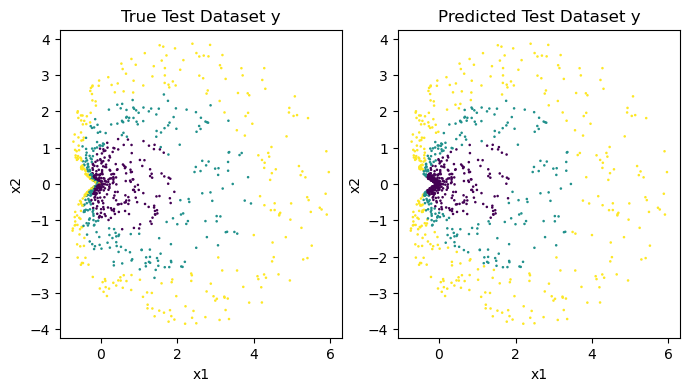

Epoch: 1800, Accuracy: 73.80 %


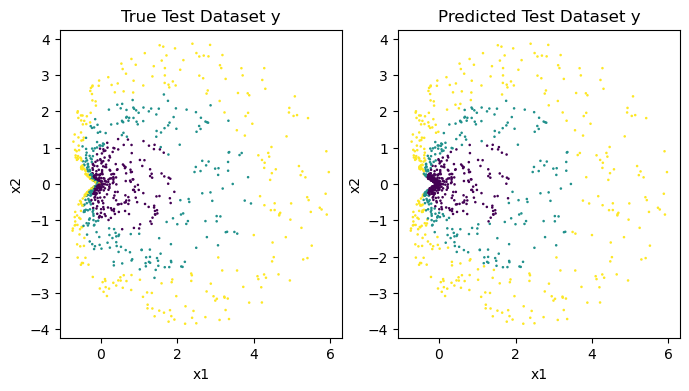

Epoch: 2000, Accuracy: 74.30 %


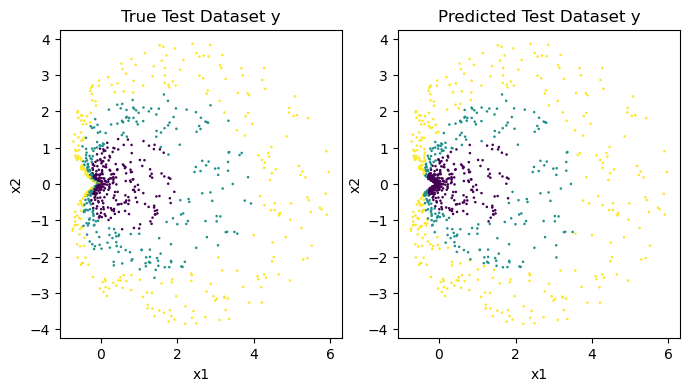

Epoch: 2200, Accuracy: 74.80 %


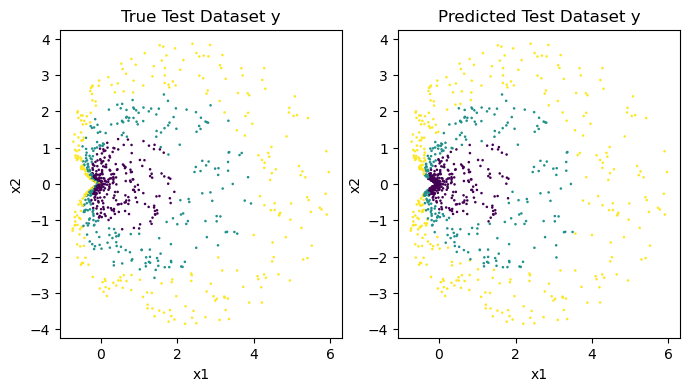

Epoch: 2400, Accuracy: 75.00 %


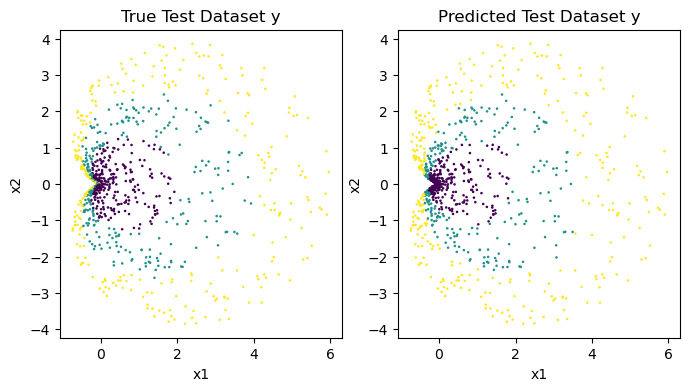

Epoch: 2600, Accuracy: 76.40 %


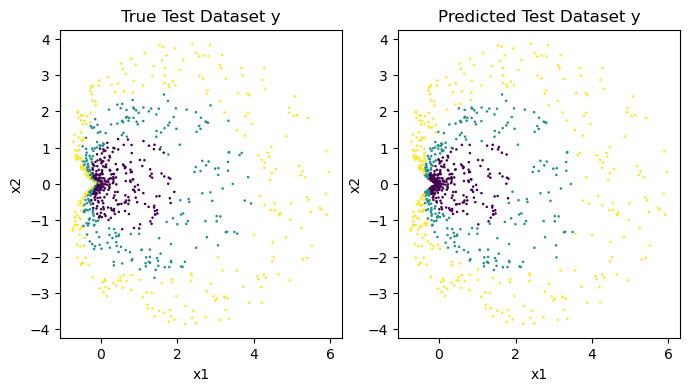

Epoch: 2800, Accuracy: 76.60 %


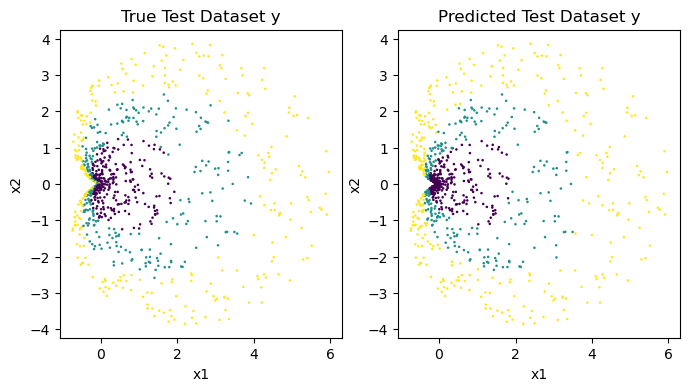

Epoch: 3000, Accuracy: 77.20 %


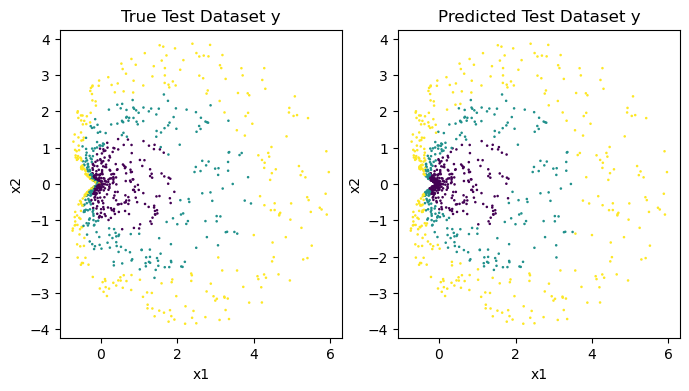

Epoch: 3200, Accuracy: 77.60 %


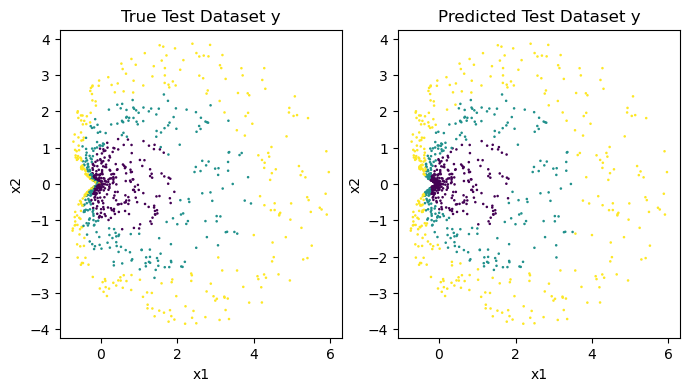

Epoch: 3400, Accuracy: 77.80 %


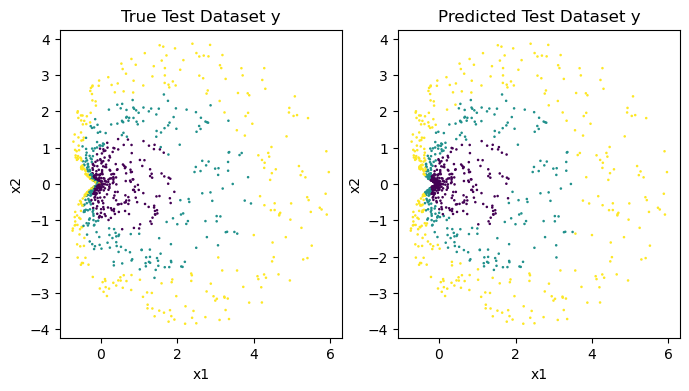

Epoch: 3600, Accuracy: 77.90 %


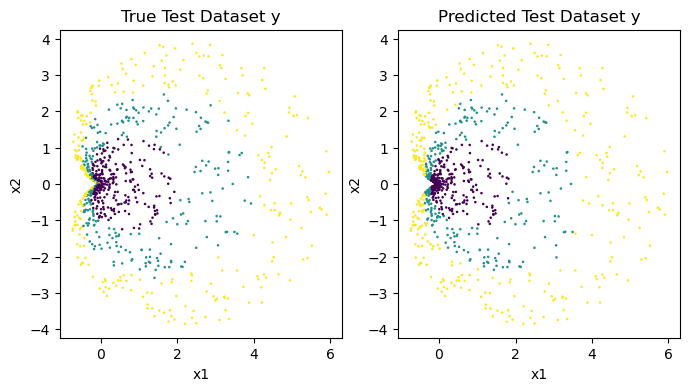

Epoch: 3800, Accuracy: 78.00 %


In [12]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ===== Construct Model ====== #
# model = LinearModel()
model = MLPModel()

print(f"{sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

# ====== Construct Optimizer ====== #
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

list_epoch = []

list_train_loss = []
list_val_loss = []

list_accuracy = []
list_accuracy_epoch = []

epoch = 4000
for i in range(epoch):

    # ====== Training ====== #
    model.train()
    optimizer.zero_grad()

    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y).long()
    pred_y = model(input_x)

    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward()
    optimizer.step()

    list_epoch.append(i)
    list_train_loss.append(loss.item())


    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()

    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)

    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.item())


    # ====== Evaluation ====== #
    if i % 200 == 0:

        # ====== Calculate Accuracy ====== #
        model.eval()
        optimizer.zero_grad()

        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y).long()
        pred_y = model(input_x).detach().max(dim=1)[1]

        accuracy = accuracy_score(true_y, pred_y)
        list_accuracy.append(accuracy)
        list_accuracy_epoch.append(i)

        fig = plt.figure(figsize=(8,4))

        # ====== True Y scattering ====== #
        ax1 = fig.add_subplot(121)
        ax1.scatter(test_X[:,0], test_X[:,1], c=test_y, s=0.7)
        ax1.set_xlabel('x1'); ax1.set_ylabel('x2')
        ax1.set_title('True Test Dataset y')

        # ====== Predicted Y scattering ====== #
        ax2 = fig.add_subplot(122)
        ax2.scatter(test_X[:,0], test_X[:,1], c=pred_y, s=0.7)
        ax2.set_xlabel('x1'); ax2.set_ylabel('x2')
        ax2.set_title('Predicted Test Dataset y')

        plt.show()
        print(f"Epoch: {i}, Accuracy: {accuracy*100:.2f} %")


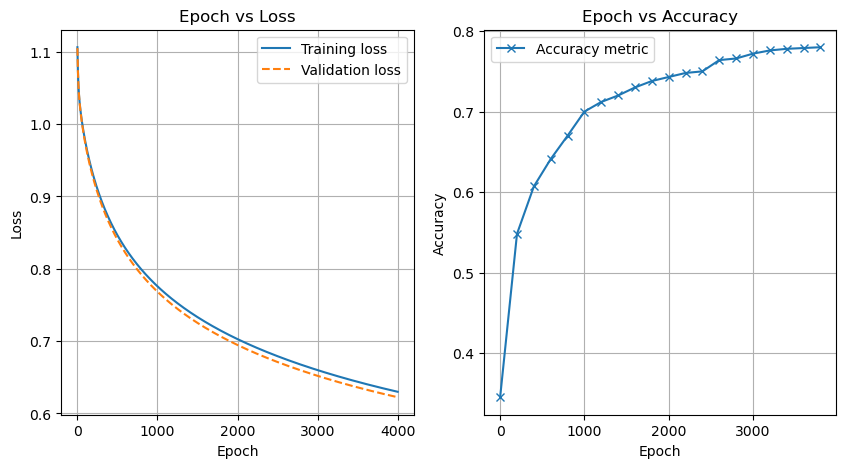

In [15]:
fig = plt.figure(figsize=(10,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(121)
ax1.plot(list_epoch, list_train_loss, label='Training loss')
ax1.plot(list_epoch, list_val_loss, '--', label='Validation loss')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()
ax1.set_title('Epoch vs Loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(122)
ax2.plot(list_accuracy_epoch, list_accuracy, marker='x', label='Accuracy metric')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()
ax2.set_title('Epoch vs Accuracy')

plt.show()